<a href="https://colab.research.google.com/github/Raghav789-code/SRGAN/blob/main/SoC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install and Import Libraries
# Make sure you have a GPU runtime selected in your notebook environment (e.g., Google Colab)

!pip install torch torchvision matplotlib pillow numpy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Step 2: Download and Prepare the Dataset

# Download and extract the dataset
!wget -q https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -xzf BSDS300-images.tgz

# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        # Ensure images are in RGB format
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations to apply to the images
# We resize them to a fixed size for consistent training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1, 1]
])

# Create Dataset and DataLoader instances
# Make sure the path "BSDS300/images/train" exists after extraction
dataset = ImageDataset(root_dir="BSDS300/images/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
# Step 3: Define the Model Architecture

# Residual-in-Residual Dense Block (RRDB)
class RRDB(nn.Module):
    def __init__(self, in_channels, growth_channels=32):
        super(RRDB, self).__init__()
        # Simplified dense connections for clarity
        self.conv1 = nn.Conv2d(in_channels, growth_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels + growth_channels, growth_channels, 3, 1, 1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_channels, growth_channels, 3, 1, 1)
        self.conv4 = nn.Conv2d(in_channels + 3 * growth_channels, growth_channels, 3, 1, 1)
        self.conv5 = nn.Conv2d(in_channels + 4 * growth_channels, in_channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        # Scale residual by 0.2 and add to input
        return x + x5 * 0.2

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_filters=64, n_rrdb=16):
        super(Generator, self).__init__()
        # Initial convolution
        self.conv_in = nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1)

        # RRDB blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(n_filters) for _ in range(n_rrdb)])

        # Final convolution
        self.conv_out = nn.Conv2d(n_filters, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Note: This generator does not perform upsampling, it enhances at the same resolution.
        # A true super-resolution model would have upsampling layers (e.g., PixelShuffle).
        initial_features = self.conv_in(x)
        rrdb_features = self.rrdb_blocks(initial_features)
        return self.conv_out(rrdb_features)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride=1, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128, stride=2),
            *discriminator_block(128, 256, stride=2),
            *discriminator_block(256, 512, stride=2),
            nn.Conv2d(512, 1, 3, 1, 1) # Final layer outputs a single value (realness score)
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
# Step 4: Define the Loss Functions

# We'll use L1 Loss for content, which is common for image-to-image tasks
criterion_content = nn.L1Loss()
criterion_gan = nn.BCEWithLogitsLoss() # Adversarial loss

# Perceptual Loss using a pre-trained VGG19 model
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features[:35].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, generated, real):
        gen_features = self.vgg(generated)
        real_features = self.vgg(real)
        return F.l1_loss(gen_features, real_features)

criterion_perceptual = PerceptualLoss()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 92.7MB/s]


In [ ]:
# CORRECTED Step 5: Define the Training Loop

def train(generator, discriminator, dataloader, optim_G, optim_D, num_epochs, device):
    # Move models and losses to the selected device (GPU or CPU)
    generator.to(device)
    discriminator.to(device)
    criterion_content.to(device)
    criterion_perceptual.to(device)
    criterion_gan.to(device)

    # Loss weights
    lambda_content = 1.0
    lambda_adv = 0.005
    lambda_perceptual = 0.01

    for epoch in range(num_epochs):
        for i, hr_imgs in enumerate(dataloader):
            hr_imgs = hr_imgs.to(device)

            # --- Create adversarial ground truths (THE FIX IS HERE) ---
            # The discriminator output shape for a 128x128 input is 16x16.
            # We create the valid/fake labels to match this shape.
            disc_output_shape = (hr_imgs.size(0), 1, 16, 16)
            valid = torch.ones(disc_output_shape, device=device)
            fake = torch.zeros(disc_output_shape, device=device)

            # --- Train Generator ---
            optim_G.zero_grad()

            # Generate super-resolved images
            sr_imgs = generator(hr_imgs)

            # Calculate losses
            loss_content = criterion_content(sr_imgs, hr_imgs)
            loss_adv = criterion_gan(discriminator(sr_imgs), valid)
            loss_perceptual = criterion_perceptual(sr_imgs, hr_imgs)

            # Total Generator loss
            g_loss = lambda_content * loss_content + lambda_adv * loss_adv + lambda_perceptual * loss_perceptual

            g_loss.backward()
            optim_G.step()

            # --- Train Discriminator ---
            optim_D.zero_grad()

            # Loss for real and fake images
            loss_real = criterion_gan(discriminator(hr_imgs), valid)
            loss_fake = criterion_gan(discriminator(sr_imgs.detach()), fake)

            # Total Discriminator loss
            d_loss = (loss_real + loss_fake) / 2

            d_loss.backward()
            optim_D.step()

            # --- Log Progress ---
            if (i + 1) % 50 == 0:
                print(
                    f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(dataloader)}] "
                    f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
                )

In [ ]:
# Step 6: Initialize Models and Start Training

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Generator, Discriminator, and Optimizers
generator = Generator(n_rrdb=8).to(device) # Using fewer RRDBs to speed up training
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Start training!
# For a real result, you would train for many more epochs (e.g., 100+).
# We use 5 epochs here as a quick demonstration.
train(generator, discriminator, dataloader, optimizer_G, optimizer_D, num_epochs=5, device=device)

Using device: cuda


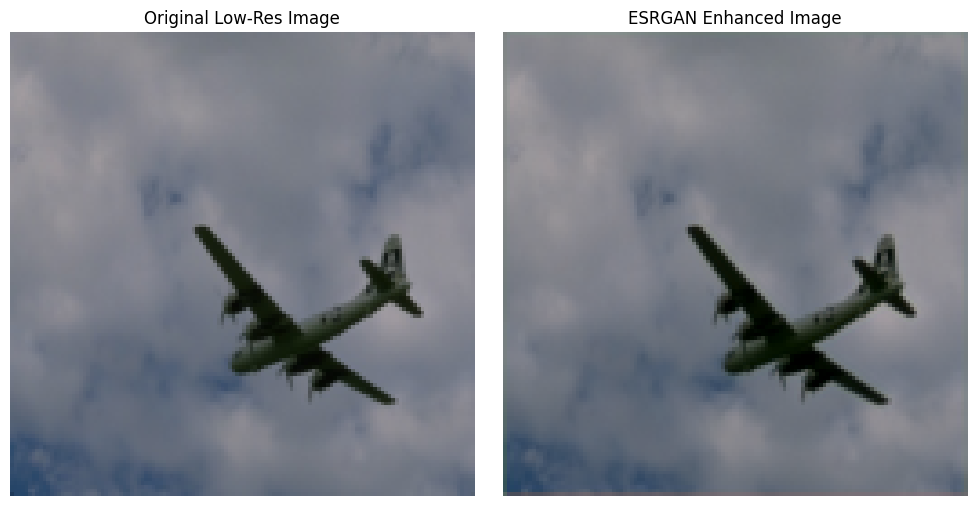

In [ ]:
# Step 7: Test the Model and Visualize Results

# Helper function to denormalize and display images
def show_image(tensor, title=""):
    tensor = tensor.detach().cpu()
    # Denormalize from [-1, 1] to [0, 1]
    tensor = tensor.mul(0.5).add(0.5)
    image = tensor.squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Load a test image
test_image_path = "BSDS300/images/test/3096.jpg"
test_image = Image.open(test_image_path).convert("RGB")
test_tensor = transform(test_image).unsqueeze(0).to(device)

# Generate the super-resolved image
generator.eval() # Set generator to evaluation mode
with torch.no_grad():
    sr_tensor = generator(test_tensor)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_image(test_tensor, "Original Low-Res Image")

plt.subplot(1, 2, 2)
show_image(sr_tensor, "ESRGAN Enhanced Image")

plt.tight_layout()
plt.show()

# Save the final image
save_image(sr_tensor.mul(0.5).add(0.5), "enhanced_image.png")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.XJPVA6_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.XJPVA6_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.
DIV2K dataset downloaded and loaded.
Starting image preprocessing...
Processed and saved 100 image pairs.
Processed and saved 200 image pairs.
Processed and saved 300 image pairs.
Processed and saved 400 image pairs.
Processed and saved 500 image pairs.
Processed and saved 600 image pairs.
Processed and saved 700 image pairs.
Processed and saved 800 image pairs.
Image preprocessing complete.
Custom dataset created. Number of samples: 800
DataLoader created.


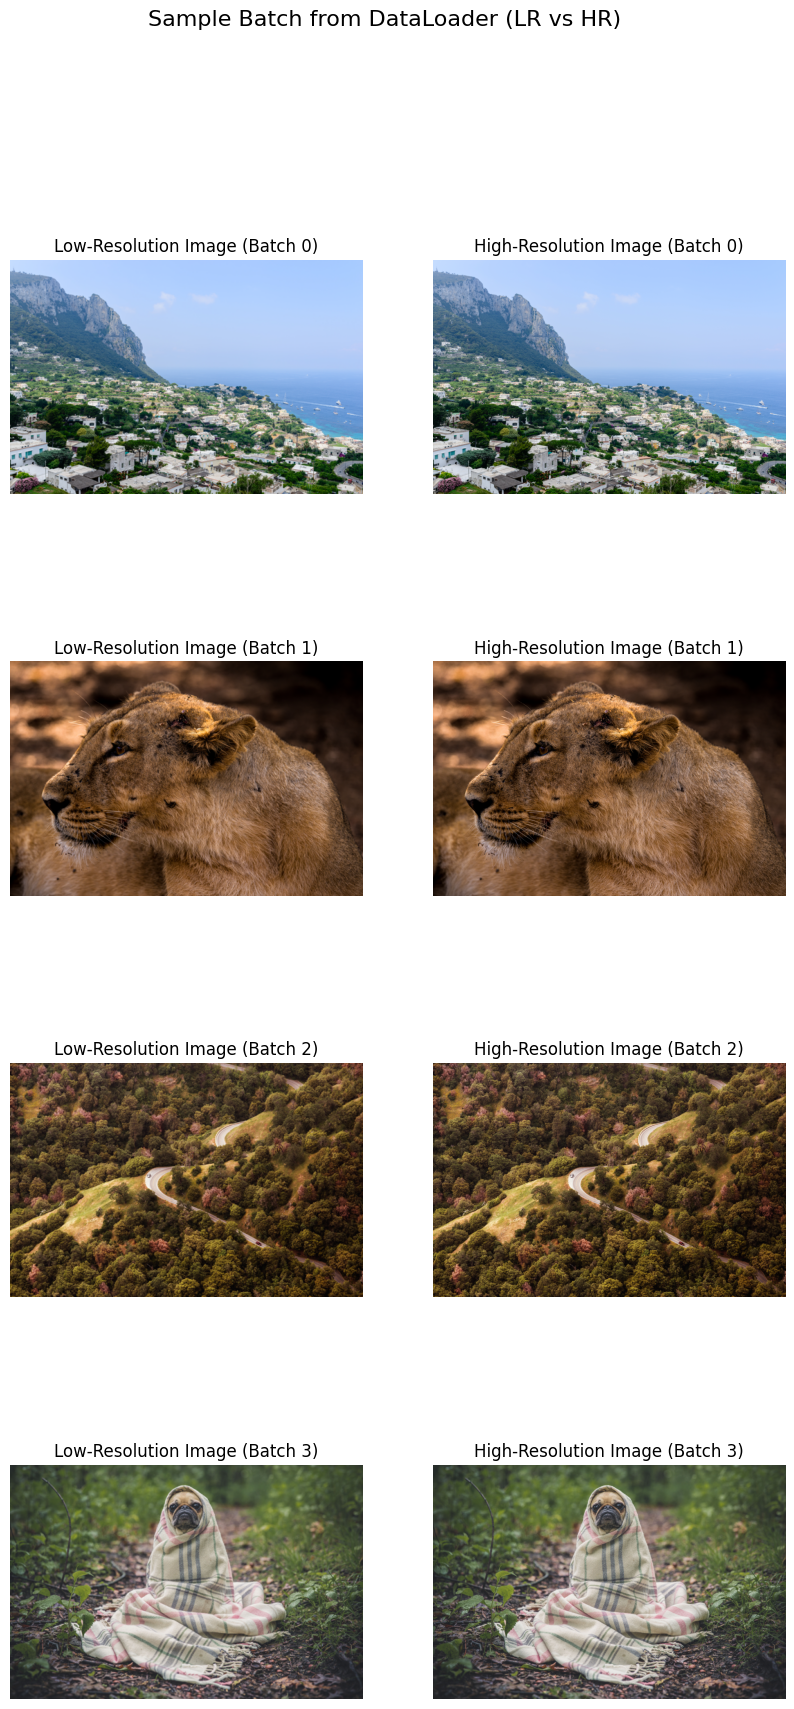

In [ ]:
#@title 1. Setup and Imports
# It's recommended to use a GPU runtime for this notebook.
# Go to Runtime -> Change runtime type and select GPU as the hardware accelerator.

!pip install tensorflow_datasets Pillow torch torchvision

import tensorflow_datasets as tfds
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import shutil
from google.colab import files
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)

#@title 2. Download the DIV2K Dataset
# We will use the TensorFlow Datasets library to download and prepare the DIV2K dataset.
# This will download the 'bicubic_x4' configuration, which provides high-resolution (HR)
# images and their corresponding low-resolution (LR) images downscaled by a factor of 4
# using bicubic interpolation.

# The data will be downloaded to the default TensorFlow Datasets directory in your
# Colab environment, typically /root/tensorflow_datasets/
div2k_data = tfds.load('div2k/bicubic_x4', split='train', as_supervised=True)
print("DIV2K dataset downloaded and loaded.")

#@title 3. Preprocess and Create LR-HR Image Pairs
# In this step, we will iterate through the downloaded dataset, extract the
# high-resolution images, and create our own low-resolution images by downsampling
# them. This gives us more control over the preprocessing pipeline. We will save
# these image pairs to dedicated directories in our Colab environment.

# Create directories to store the processed images
os.makedirs('DIV2K/HR', exist_ok=True)
os.makedirs('DIV2K/LR_bicubic_x4', exist_ok=True)

def preprocess_and_save(dataset, hr_dir, lr_dir, scale_factor=4):
    """
    Iterates through the dataset, saves HR images, generates LR images by
    bicubic downsampling, and saves them.
    """
    for i, (lr_image_tensor, hr_image_tensor) in enumerate(dataset):
        # Convert TensorFlow tensors to PIL Images
        hr_image = Image.fromarray(hr_image_tensor.numpy())

        # Save the high-resolution image
        hr_image_path = os.path.join(hr_dir, f'{i:04d}.png')
        hr_image.save(hr_image_path)

        # Create the low-resolution image via bicubic downsampling
        hr_width, hr_height = hr_image.size
        lr_width, lr_height = hr_width // scale_factor, hr_height // scale_factor
        lr_image = hr_image.resize((lr_width, lr_height), Image.BICUBIC)

        # Save the low-resolution image
        lr_image_path = os.path.join(lr_dir, f'{i:04d}x4.png')
        lr_image.save(lr_image_path)

        if (i + 1) % 100 == 0:
            print(f"Processed and saved {i + 1} image pairs.")

print("Starting image preprocessing...")
preprocess_and_save(div2k_data, 'DIV2K/HR', 'DIV2K/LR_bicubic_x4')
print("Image preprocessing complete.")


#@title 4. Create a Custom PyTorch Dataset
# Now, we'll create a custom Dataset class in PyTorch. This class will handle
# loading our preprocessed LR and HR image pairs from the directories we just created.
# This is a standard and highly recommended practice for working with image data in PyTorch.

class DIV2KDataset(Dataset):
    """
    Custom PyTorch Dataset for the DIV2K dataset.
    """
    def __init__(self, hr_dir, lr_dir, transform=None):
        """
        Args:
            hr_dir (string): Directory with all the high-resolution images.
            lr_dir (string): Directory with all the low-resolution images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.transform = transform
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_images = sorted(os.listdir(lr_dir))

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        hr_image_path = os.path.join(self.hr_dir, self.hr_images[idx])
        # The LR image names have an 'x4' suffix, so we need to construct the name
        lr_image_name = self.hr_images[idx].replace('.png', 'x4.png')
        lr_image_path = os.path.join(self.lr_dir, lr_image_name)

        hr_image = Image.open(hr_image_path).convert('RGB')
        lr_image = Image.open(lr_image_path).convert('RGB')

        sample = {'lr': lr_image, 'hr': hr_image}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example of a transform to convert images to tensors
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        lr = np.array(lr).transpose((2, 0, 1))
        hr = np.array(hr).transpose((2, 0, 1))
        return {'lr': torch.from_numpy(lr).float(),
                'hr': torch.from_numpy(hr).float()}

# Create an instance of our custom dataset
div2k_dataset = DIV2KDataset(hr_dir='DIV2K/HR',
                               lr_dir='DIV2K/LR_bicubic_x4',
                               transform=ToTensor())

print(f"Custom dataset created. Number of samples: {len(div2k_dataset)}")


#@title 5. Create a PyTorch DataLoader
# The DataLoader provides an iterable over the dataset, with support for
# batching, shuffling, and multi-threaded data loading. This is the standard
# way to feed data into a PyTorch model.

dataloader = DataLoader(div2k_dataset, batch_size=4,
                        shuffle=True, num_workers=2)

print("DataLoader created.")

#@title 6. Visualize a Sample from the DataLoader
# Let's fetch a batch of data from our DataLoader and visualize it to
# ensure everything is working correctly.

def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    lr_batch, hr_batch = \
            sample_batched['lr'], sample_batched['hr']
    batch_size = len(lr_batch)
    im_size = lr_batch.size(2)
    grid_border_size = 2

    # Create a grid of images
    fig, axes = plt.subplots(batch_size, 2, figsize=(10, batch_size * 5))
    fig.suptitle('Sample Batch from DataLoader (LR vs HR)', fontsize=16)

    for i in range(batch_size):
        # Convert tensors to numpy arrays for plotting
        lr_image = lr_batch[i].numpy().transpose((1, 2, 0)).astype('uint8')
        hr_image = hr_batch[i].numpy().transpose((1, 2, 0)).astype('uint8')

        axes[i, 0].imshow(lr_image)
        axes[i, 0].set_title(f'Low-Resolution Image (Batch {i})')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(hr_image)
        axes[i, 1].set_title(f'High-Resolution Image (Batch {i})')
        axes[i, 1].axis('off')

    plt.show()

# Fetch one batch from the dataloader
sample_batch = next(iter(dataloader))
show_batch(sample_batch)

#@title 7. Clean up (Optional)
# If you want to remove the downloaded and processed image directories to save space.
# shutil.rmtree('DIV2K')
# shutil.rmtree('/root/tensorflow_datasets/div2k')


In [ ]:
#@title 1. Setup and Imports
# It's recommended to use a GPU runtime for this notebook.
# Go to Runtime -> Change runtime type and select GPU as the hardware accelerator.

!pip install tensorflow_datasets Pillow torch torchvision piq

import tensorflow_datasets as tfds
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import piq

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)
print("PIQ version:", piq.__version__)

TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
PIQ version: 0.8.0


In [ ]:
#@title 2. Download and Preprocess Data
# This cell will download the DIV2K dataset and process it.
# The processed images will be stored in the local Colab runtime.
# NOTE: This data will be deleted when the Colab runtime is disconnected or reset.

# Define the local directories where data will be stored.
HR_DIR = 'DIV2K/HR'
LR_DIR = 'DIV2K/LR_bicubic_x4'

# Create the directories
os.makedirs(HR_DIR, exist_ok=True)
os.makedirs(LR_DIR, exist_ok=True)

def preprocess_and_save(dataset, hr_dir, lr_dir, scale_factor=4):
    """
    Iterates through the dataset, saves HR images, generates LR images by
    bicubic downsampling, and saves them to the specified local directories.
    """
    print("Starting image preprocessing...")
    for i, (lr_image_tensor, hr_image_tensor) in enumerate(dataset):
        # Convert TensorFlow tensors to PIL Images
        hr_image = Image.fromarray(hr_image_tensor.numpy())

        # Save the high-resolution image
        hr_image_path = os.path.join(hr_dir, f'{i:04d}.png')
        hr_image.save(hr_image_path)

        # Create the low-resolution image via bicubic downsampling
        hr_width, hr_height = hr_image.size
        lr_width, lr_height = hr_width // scale_factor, hr_height // scale_factor
        lr_image = hr_image.resize((lr_width, lr_height), Image.BICUBIC)

        # Save the low-resolution image
        lr_image_path = os.path.join(lr_dir, f'{i:04d}x4.png')
        lr_image.save(lr_image_path)

        if (i + 1) % 100 == 0:
            print(f"Processed and saved {i + 1} image pairs.")
    print("Image preprocessing complete.")

# The data will be downloaded to the default TensorFlow Datasets directory in your
# Colab environment, typically /root/tensorflow_datasets/
div2k_data = tfds.load('div2k/bicubic_x4', split='train', as_supervised=True)
print("DIV2K dataset downloaded.")

preprocess_and_save(div2k_data, HR_DIR, LR_DIR)

DIV2K dataset downloaded.
Starting image preprocessing...
Processed and saved 100 image pairs.
Processed and saved 200 image pairs.
Processed and saved 300 image pairs.
Processed and saved 400 image pairs.
Processed and saved 500 image pairs.
Processed and saved 600 image pairs.
Processed and saved 700 image pairs.
Processed and saved 800 image pairs.
Image preprocessing complete.


In [ ]:
#@title 3. Create a Custom PyTorch Dataset with Patching
# Now, we'll create a custom Dataset class in PyTorch. This class will handle
# loading our preprocessed LR and HR image pairs from the local directories.
#
# **IMPORTANT FIX**: To solve the "Trying to resize storage that is not resizable" error,
# we will not use the full images. Instead, we will randomly crop a small patch from the
# LR image and a corresponding, larger patch from the HR image. This ensures that every
# item in a batch has the same size, which is required by the DataLoader.

class DIV2KDataset(Dataset):
    """
    Custom PyTorch Dataset for the DIV2K dataset.
    It returns random patches of a fixed size.
    """
    def __init__(self, hr_dir, lr_dir, patch_size=48, scale=4, transform=None):
        """
        Args:
            hr_dir (string): Directory with all the high-resolution images.
            lr_dir (string): Directory with all the low-resolution images.
            patch_size (int): The size of the patch to be cropped from the LR images.
            scale (int): The super-resolution scale factor.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.transform = transform
        self.hr_images = sorted(os.listdir(hr_dir))
        self.patch_size = patch_size
        self.scale = scale

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        hr_image_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_image_name = self.hr_images[idx].replace('.png', 'x4.png')
        lr_image_path = os.path.join(self.lr_dir, lr_image_name)

        hr_image = Image.open(hr_image_path).convert('RGB')
        lr_image = Image.open(lr_image_path).convert('RGB')

        # Get random patch
        lr_w, lr_h = lr_image.size
        hr_w, hr_h = hr_image.size

        # Define patch size for HR image
        hr_patch_size = self.patch_size * self.scale

        # Get random top-left corner for LR patch
        lr_x = np.random.randint(0, lr_w - self.patch_size + 1)
        lr_y = np.random.randint(0, lr_h - self.patch_size + 1)

        # Get corresponding top-left corner for HR patch
        hr_x = lr_x * self.scale
        hr_y = lr_y * self.scale

        # Crop patches using PIL's crop method
        # The crop box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
        lr_patch = lr_image.crop((lr_x, lr_y, lr_x + self.patch_size, lr_y + self.patch_size))
        hr_patch = hr_image.crop((hr_x, hr_y, hr_x + hr_patch_size, hr_y + hr_patch_size))

        # Normalize images to [0, 1] range
        hr_patch = np.array(hr_patch) / 255.0
        lr_patch = np.array(lr_patch) / 255.0

        sample = {'lr': lr_patch, 'hr': hr_patch}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example of a transform to convert images to tensors
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        lr = lr.transpose((2, 0, 1))
        hr = hr.transpose((2, 0, 1))
        return {'lr': torch.from_numpy(lr).float(),
                'hr': torch.from_numpy(hr).float()}

# Create an instance of our custom dataset using the local paths
full_dataset = DIV2KDataset(hr_dir=HR_DIR,
                               lr_dir=LR_DIR,
                               transform=ToTensor())

print(f"Full dataset created. Number of samples: {len(full_dataset)}")

Full dataset created. Number of samples: 800


In [ ]:
#@title 4. Create Training and Validation Sets
# It's crucial to have a separate validation set to evaluate the model's performance
# on unseen data. We'll split our full dataset into a training set and a validation set.
VAL_SPLIT = 0.1
dataset_size = len(full_dataset)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create DataLoaders for both training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

print("Training and validation DataLoaders created.")

Training set size: 720
Validation set size: 80
Training and validation DataLoaders created.


In [ ]:
#@title 5. Define the Super-Resolution Model (SRCNN)
# Here we define a simple but effective Super-Resolution Convolutional Neural Network (SRCNN).
# It consists of three convolutional layers:
# 1. Patch extraction and representation
# 2. Non-linear mapping
# 3. Reconstruction
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # First, we upscale the LR image to the target size using bicubic interpolation.
        # The network then learns to correct/refine this upscaled image.
        x = nn.functional.interpolate(x, scale_factor=4, mode='bicubic', align_corners=False)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
#@title 6. Setup Training Components
# We'll set up the device, model, loss function, optimizer, and learning rate scheduler.
# Note on Label Smoothing: This is a technique for classification tasks to prevent
# overconfidence. For regression tasks like super-resolution, the equivalent is
# ensuring the model isn't overly penalized for minor pixel deviations. Using a robust
# loss like L1 (Mean Absolute Error) instead of L2 (MSE) serves a similar purpose,
# as it's less sensitive to outliers.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SRCNN().to(device)
criterion = nn.L1Loss() # L1 Loss is often preferred for image-to-image tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler: Reduces the learning rate by a factor of 0.1 every 5 epochs.
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

Using device: cuda


In [ ]:
#@title 7. The Training Loop
# This is where the model learns. We iterate through the data for a set number of epochs,
# updating the model's weights to minimize the loss. We also evaluate performance on the
# validation set at the end of each epoch.

NUM_EPOCHS = 10 # For a real training session, this should be much higher (e.g., 50-100)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        lr_images, hr_images = data['lr'].to(device), data['hr'].to(device)

        optimizer.zero_grad()

        sr_images = model(lr_images)
        loss = criterion(sr_images, hr_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_psnr = 0.0
    val_ssim = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            lr_images, hr_images = data['lr'].to(device), data['hr'].to(device)
            sr_images = model(lr_images).clamp(0, 1) # Clamp output to valid image range [0, 1]

            val_psnr += piq.psnr(sr_images, hr_images, data_range=1.0)
            val_ssim += piq.ssim(sr_images, hr_images, data_range=1.0)

    avg_loss = running_loss / len(train_dataloader)
    avg_psnr = val_psnr / len(val_dataloader)
    avg_ssim = val_ssim / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {avg_loss:.4f} | Val PSNR: {avg_psnr:.4f} | Val SSIM: {avg_ssim:.4f}")

    scheduler.step() # Update learning rate

print("Finished Training")

Epoch [1/10] | Loss: 0.1189 | Val PSNR: 20.5649 | Val SSIM: 0.6568
Epoch [2/10] | Loss: 0.0599 | Val PSNR: 22.4316 | Val SSIM: 0.6745
Epoch [3/10] | Loss: 0.0536 | Val PSNR: 22.7793 | Val SSIM: 0.6834
Epoch [4/10] | Loss: 0.0477 | Val PSNR: 23.7898 | Val SSIM: 0.7315
Epoch [5/10] | Loss: 0.0449 | Val PSNR: 24.1655 | Val SSIM: 0.7063
Epoch [6/10] | Loss: 0.0399 | Val PSNR: 24.3758 | Val SSIM: 0.7076
Epoch [7/10] | Loss: 0.0391 | Val PSNR: 25.8717 | Val SSIM: 0.7584
Epoch [8/10] | Loss: 0.0383 | Val PSNR: 24.8521 | Val SSIM: 0.7198
Epoch [9/10] | Loss: 0.0392 | Val PSNR: 24.5843 | Val SSIM: 0.7279
Epoch [10/10] | Loss: 0.0382 | Val PSNR: 25.2089 | Val SSIM: 0.7131
Finished Training


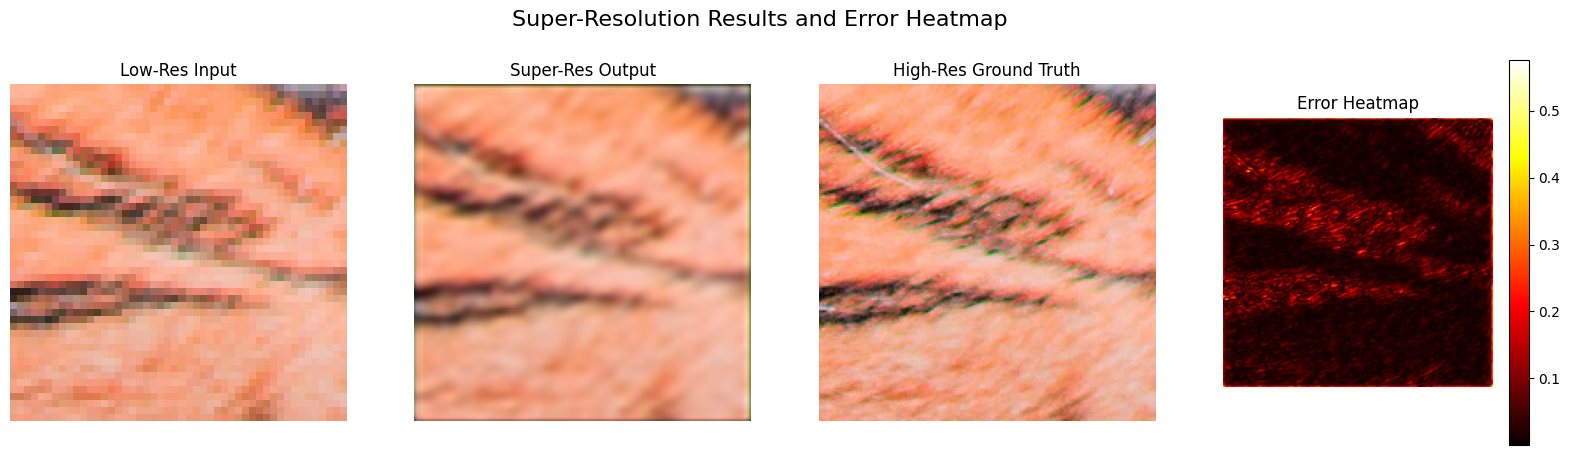

In [ ]:
#@title 8. Visualize Results and Error Heatmap
# Let's take a sample from the validation set and see how our trained model performs.
# We will show the Low-Res input, the model's Super-Res output, and the High-Res ground truth.
# We will also visualize the difference between our output and the ground truth as a heatmap.

model.eval()
with torch.no_grad():
    sample_data = next(iter(val_dataloader))
    lr_image = sample_data['lr'].to(device)
    hr_image = sample_data['hr'].to(device)

    # Get the model's output
    sr_image = model(lr_image).clamp(0, 1)

    # Move images to CPU and convert to numpy for plotting
    lr_plot = lr_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    hr_plot = hr_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    sr_plot = sr_image.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Calculate the difference (residual) map
    diff_map = np.abs(hr_plot - sr_plot)
    # We can take the mean across color channels for a single grayscale heatmap
    diff_map_gray = diff_map.mean(axis=2)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('Super-Resolution Results and Error Heatmap', fontsize=16)

    # Low-Resolution Image
    axes[0].imshow(lr_plot)
    axes[0].set_title("Low-Res Input")
    axes[0].axis('off')

    # Super-Resolution Output
    axes[1].imshow(sr_plot)
    axes[1].set_title("Super-Res Output")
    axes[1].axis('off')

    # High-Resolution Ground Truth
    axes[2].imshow(hr_plot)
    axes[2].set_title("High-Res Ground Truth")
    axes[2].axis('off')

    # Difference Heatmap
    im = axes[3].imshow(diff_map_gray, cmap='hot')
    axes[3].set_title("Error Heatmap")
    axes[3].axis('off')
    fig.colorbar(im, ax=axes[3])

    plt.show()

In [ ]:
#@title 1. Setup and Imports
# It's recommended to use a GPU runtime for this notebook.
# Go to Runtime -> Change runtime type and select GPU as the hardware accelerator.

!pip install tensorflow_datasets Pillow torch torchvision piq

import tensorflow_datasets as tfds
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import piq

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)
print("PIQ version:", piq.__version__)

TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
PIQ version: 0.8.0


In [ ]:
#@title 1. Setup and Imports
# It's recommended to use a GPU runtime for this notebook.
# Go to Runtime -> Change runtime type and select GPU as the hardware accelerator.

!pip install tensorflow_datasets Pillow torch torchvision piq

import tensorflow_datasets as tfds
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import piq

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)
print("PIQ version:", piq.__version__)

TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
PIQ version: 0.8.0


In [ ]:
#@title 3. Create a Custom PyTorch Dataset with Patching
# This class correctly loads and provides random patches of data.
class DIV2KDataset(Dataset):
    """
    Custom PyTorch Dataset for the DIV2K dataset.
    It returns random patches of a fixed size.
    """
    def __init__(self, hr_dir, lr_dir, patch_size=48, scale=4, transform=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.transform = transform
        self.hr_images = sorted(os.listdir(hr_dir))
        self.patch_size = patch_size
        self.scale = scale

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        # **ERROR HANDLING FIX**: Wrap the image loading in a try-except block.
        # If an image is corrupted, it will catch the OSError and try to load the next image instead.
        try:
            hr_image_path = os.path.join(self.hr_dir, self.hr_images[idx])
            lr_image_name = self.hr_images[idx].replace('.png', 'x4.png')
            lr_image_path = os.path.join(self.lr_dir, lr_image_name)

            hr_image = Image.open(hr_image_path).convert('RGB')
            lr_image = Image.open(lr_image_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f"Warning: Skipping corrupted image file: {self.hr_images[idx]}. Error: {e}")
            # Recursively call __getitem__ with the next index until a valid image is found.
            # The modulo operator (%) ensures we wrap around to the beginning if the last image is corrupt.
            return self.__getitem__((idx + 1) % len(self))


        # Get random patch
        lr_w, lr_h = lr_image.size
        hr_w, hr_h = hr_image.size

        # Define patch size for HR image
        hr_patch_size = self.patch_size * self.scale

        # Get random top-left corner for LR patch
        lr_x = np.random.randint(0, lr_w - self.patch_size + 1)
        lr_y = np.random.randint(0, lr_h - self.patch_size + 1)

        # Get corresponding top-left corner for HR patch
        hr_x = lr_x * self.scale
        hr_y = lr_y * self.scale

        # Crop patches using PIL's crop method
        # The crop box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.
        lr_patch = lr_image.crop((lr_x, lr_y, lr_x + self.patch_size, lr_y + self.patch_size))
        hr_patch = hr_image.crop((hr_x, hr_y, hr_x + hr_patch_size, hr_y + hr_patch_size))

        # Normalize images to [0, 1] range
        hr_patch = np.array(hr_patch) / 255.0
        lr_patch = np.array(lr_patch) / 255.0

        sample = {'lr': lr_patch, 'hr': hr_patch}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']
        lr = lr.transpose((2, 0, 1))
        hr = hr.transpose((2, 0, 1))
        return {'lr': torch.from_numpy(lr).float(), 'hr': torch.from_numpy(hr).float()}

full_dataset = DIV2KDataset(hr_dir=HR_DIR, lr_dir=LR_DIR, transform=ToTensor())
print(f"Full dataset created. Number of samples: {len(full_dataset)}")


Full dataset created. Number of samples: 68


In [ ]:
#@title 4. Create Training and Validation Sets
VAL_SPLIT = 0.1
dataset_size = len(full_dataset)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
print("Training and validation DataLoaders created.")

Training set size: 62
Validation set size: 6
Training and validation DataLoaders created.


In [ ]:
#@title 5. Define the Super-Resolution Model (SRCNN)
# We use the simpler SRCNN model for a faster training demo.
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=4, mode='bicubic', align_corners=False)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
#@title 6. Setup Training Components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SRCNN().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [ ]:
#@title 7. The Training Loop
NUM_EPOCHS = 5 # Reduced for a quick demo

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        lr_images, hr_images = data['lr'].to(device), data['hr'].to(device)

        optimizer.zero_grad()
        sr_images = model(lr_images)
        loss = criterion(sr_images, hr_images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_psnr = 0.0
    val_ssim = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            lr_imgs, hr_imgs = data['lr'].to(device), data['hr'].to(device)
            sr_imgs = model(lr_imgs).clamp(0, 1)
            val_psnr += piq.psnr(sr_imgs, hr_imgs, data_range=1.0)
            val_ssim += piq.ssim(sr_imgs, hr_imgs, data_range=1.0)

    avg_loss = running_loss / len(train_dataloader)
    avg_psnr = val_psnr / len(val_dataloader)
    avg_ssim = val_ssim / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {avg_loss:.4f} | Val PSNR: {avg_psnr:.4f} | Val SSIM: {avg_ssim:.4f}")

# --- Save Final Model ---
torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'srcnn_final.pth'))
print("Finished Training and saved final model.")

Epoch [1/5] | Loss: 0.2630 | Val PSNR: 15.3518 | Val SSIM: 0.6048
Epoch [2/5] | Loss: 0.1419 | Val PSNR: 19.0995 | Val SSIM: 0.7182
Epoch [3/5] | Loss: 0.1125 | Val PSNR: 20.2213 | Val SSIM: 0.7348
Epoch [4/5] | Loss: 0.0851 | Val PSNR: 18.9539 | Val SSIM: 0.5567
Epoch [5/5] | Loss: 0.0783 | Val PSNR: 19.3818 | Val SSIM: 0.6576
Finished Training and saved final model.


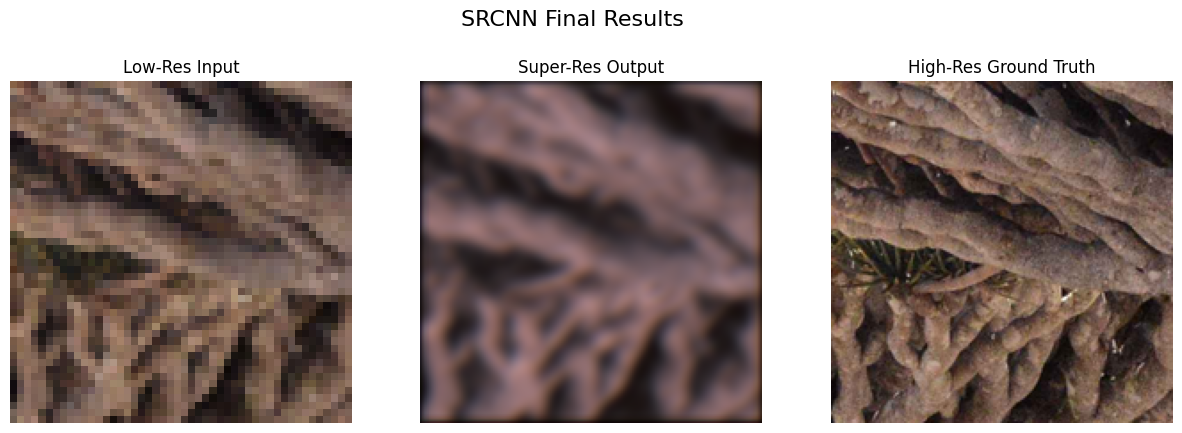

In [ ]:
#@title 8. Visualize Final Result
# Load the final model and visualize its performance on a sample image.
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, 'srcnn_final.pth')))
model.eval()

with torch.no_grad():
    sample_data = next(iter(val_dataloader))
    lr_image = sample_data['lr'].to(device)
    hr_image = sample_data['hr'].to(device)
    sr_image = model(lr_image).clamp(0, 1)

    # Move images to CPU and convert to numpy for plotting
    lr_plot = lr_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    hr_plot = hr_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    sr_plot = sr_image.squeeze().cpu().numpy().transpose(1, 2, 0)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('SRCNN Final Results', fontsize=16)

    axes[0].imshow(lr_plot)
    axes[0].set_title("Low-Res Input")
    axes[0].axis('off')

    axes[1].imshow(sr_plot)
    axes[1].set_title("Super-Res Output")
    axes[1].axis('off')

    axes[2].imshow(hr_plot)
    axes[2].set_title("High-Res Ground Truth")
    axes[2].axis('off')

    plt.show()

In [ ]:
!pip install piq tqdm wget
import os
import zipfile
import wget
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import piq
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
torch.manual_seed(0)


In [ ]:
DATA_URL = "http://data.vision.ee.ethz.ch/cvl/DIV2K/"
os.makedirs("DIV2K", exist_ok=True)

# HR images
if not os.path.exists("DIV2K/DIV2K_train_HR.zip"):
    wget.download(DATA_URL + "DIV2K_train_HR.zip", out="DIV2K/")
# LR x4 images
if not os.path.exists("DIV2K/DIV2K_train_LR_bicubic_X4.zip"):
    wget.download(DATA_URL + "DIV2K_train_LR_bicubic_X4.zip", out="DIV2K/")

# Unzip if needed
def unzip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)

unzip("DIV2K/DIV2K_train_HR.zip", "DIV2K/DIV2K_train_HR")
unzip("DIV2K/DIV2K_train_LR_bicubic_X4.zip", "DIV2K/DIV2K_train_LR_bicubic/X4")


In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform_lr, transform_hr):
        self.lr_files = sorted([
            f for f in os.listdir(lr_dir)
            if os.path.isfile(os.path.join(lr_dir, f))
               and (f.lower().endswith('.png') or f.lower().endswith('.jpg'))
        ])
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_files[idx])
        hr_path = os.path.join(self.hr_dir, self.lr_files[idx].replace('x4',''))  # fix if needed
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")
        lr = self.transform_lr(lr_img)
        hr = self.transform_hr(hr_img)
        return lr, hr


NameError: name 'Dataset' is not defined

In [ ]:
# Generator: Simple SRResNet for demo
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 3, 5, padding=2),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

# Discriminator: Simple CNN for demo
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*16*16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [ ]:
from torchvision.models import vgg19

def vgg54_features(x):
    vgg = vgg19(pretrained=True).features[:35].eval()
    for p in vgg.parameters():
        p.requires_grad = False
    # Normalize to ImageNet stats
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(x.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(x.device)
    return vgg((x-mean)/std)

def perceptual_loss(x, y):
    return nn.functional.mse_loss(vgg54_features(x), vgg54_features(y))

# Example usage inside a training step:
# loss_content = perceptual_loss(fake, hr)
# psnr = piq.psnr(fake, hr)
# ssim = piq.ssim(fake, hr)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion_G = nn.MSELoss()
criterion_D = nn.BCELoss()
opt_G = torch.optim.Adam(netG.parameters(), lr=1e-4)
opt_D = torch.optim.Adam(netD.parameters(), lr=1e-4)
scheduler_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=30, gamma=0.5)

# --- Pretraining Generator ---
epochs_pretrain = 2  # Set 100 for real
for epoch in range(epochs_pretrain):
    netG.train()
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        opt_G.zero_grad()
        fake = netG(lr)
        loss = criterion_G(fake, hr)
        loss.backward()
        opt_G.step()
    print(f"Pretrain Epoch {epoch+1}/{epochs_pretrain}, Loss: {loss.item()}")

# --- Adversarial Training (SRGAN) ---
epochs_gan = 2  # Set 100 for real
real_label = 0.9  # label smoothing
fake_label = 0

for epoch in range(epochs_gan):
    netG.train()
    netD.train()
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        # Train Discriminator
        netD.zero_grad()
        fake = netG(lr)
        output_real = netD(hr)
        output_fake = netD(fake.detach())
        loss_D = criterion_D(output_real, torch.full_like(output_real, real_label)) + \
                 criterion_D(output_fake, torch.full_like(output_fake, fake_label))
        loss_D.backward()
        opt_D.step()
        # Train Generator
        opt_G.zero_grad()
        loss_content = perceptual_loss(fake, hr)
        output_fake2 = netD(fake)
        loss_adv = criterion_D(output_fake2, torch.full_like(output_fake2, real_label))
        loss_G = loss_content + 1e-3 * loss_adv
        loss_G.backward()
        opt_G.step()

    scheduler_G.step()
    scheduler_D.step()
    print(f"GAN Epoch {epoch+1}/{epochs_gan}, Loss_G: {loss_G.item():.4f}, Loss_D: {loss_D.item():.4f}")
    # Save checkpoint
    torch.save(netG.state_dict(), f"gen_epoch{epoch+1}.pth")


In [ ]:
# Example eval on some pairs
netG.eval()
lr, hr = next(iter(train_loader))
lr, hr = lr.to(device), hr.to(device)
with torch.no_grad():
    fake = netG(lr)
psnr = piq.psnr(fake, hr)
ssim = piq.ssim(fake, hr)
print(f"Eval batch PSNR: {psnr.mean().item():.2f}, SSIM: {ssim.mean().item():.4f}")

# Visualize
plt.subplot(1,3,1)
plt.imshow(np.clip(hr[0].cpu().permute(1,2,0).numpy(),0,1))
plt.title('HR')
plt.subplot(1,3,2)
plt.imshow(np.clip(lr[0].cpu().permute(1,2,0).numpy(),0,1))
plt.title('LR')
plt.subplot(1,3,3)
plt.imshow(np.clip(fake[0].cpu().permute(1,2,0).numpy(),0,1))
plt.title('SRGAN Out')
plt.show()
